In [ ]:
# Import necessary libraries
import yaml
import pandas as pd
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np 

# Path to the folder containing YAML files
search_dir = Path(r"C:\Users\Bhuvaneshwari\Downloads\data")

# Output folder
out_dir = search_dir / "per_ticker_csvs"
out_dir.mkdir(exist_ok=True)

# Finding all YAML files
yaml_files = sorted(list(search_dir.rglob("*.yaml")))

print("Found", len(yaml_files), "yaml files")

# Collecting rows grouped by ticker
rows_by_ticker = defaultdict(list)

for yf in yaml_files:
    with yf.open("r", encoding="utf-8") as f:
        data = yaml.safe_load(f)   

    for record in data:
        ticker = record.get("Ticker")
        if not ticker:
            continue
        rows_by_ticker[ticker].append({
            "date": record.get("date"),
            "open": record.get("open"),
            "high": record.get("high"),
            "low": record.get("low"),
            "close": record.get("close"),
            "volume": record.get("volume"),
        })

# Converting each ticker list to a DataFrame
for ticker, rows in rows_by_ticker.items():
    df = pd.DataFrame(rows)
    df['date'] = pd.to_datetime(df['date'])   
    df = df.sort_values('date').reset_index(drop=True)
    df = df[["date","open","high","low","close","volume"]] 
    df.to_csv(out_dir / f"{ticker}.csv", index=False)

print("Done. Created", len(rows_by_ticker), "CSV files in", out_dir)


Found 284 yaml files
Done. Created 50 CSV files in C:\Users\Bhuvaneshwari\Downloads\data\per_ticker_csvs


In [ ]:
# Folder containing all ticker CSV files
folder = Path(r"C:\Users\Bhuvaneshwari\Downloads\data\per_ticker_csvs")

print("Adding daily returns to each CSV file...\n")

# Looping through all CSV files
for file in folder.glob("*.csv"):
    df = pd.read_csv(file)

    # Sorting by date
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)

    # Calculating daily return
    df["daily_return"] = df["close"].pct_change()

    # Saving back to the same file
    df.to_csv(file, index=False)

    print(f"Updated: {file.stem}")

print("\nDone! All CSV files now contain daily_return.")


In [ ]:
volatility_data = []

# Looping through all CSV files
for file in folder.glob("*.csv"):
    ticker = file.stem 
    df = pd.read_csv(file)

    # Calculating volatility using STD of daily returns
    volatility = df["daily_return"].std()

    # Saving the result
    volatility_data.append([ticker, volatility])

# Converting to DataFrame
vol_df = pd.DataFrame(volatility_data, columns=["Ticker", "Volatility"])

# Sorting by volatility
vol_df = vol_df.sort_values("Volatility", ascending=False)

# Showing top 10 most volatile stocks
vol_df.head(10)


In [4]:
# Folder where each ticker CSV is stored
folder = Path(r"C:\Users\Bhuvaneshwari\Downloads\data\per_ticker_csvs")

rows = []

# Looping through each CSV file
for csv_file in folder.glob("*.csv"):
    ticker = csv_file.stem
    df = pd.read_csv(csv_file)

    # Skip if daily_return column is missing
    if "daily_return" not in df.columns:
        continue

    # Calculate volatility 
    volatility = df["daily_return"].std()

    rows.append([ticker, volatility])

# Create DataFrame
vol_df = pd.DataFrame(rows, columns=["Ticker", "Volatility"])

# Sort by volatility (descending)
vol_df = vol_df.sort_values("Volatility", ascending=False)

# Save file to final_summary
output_path = folder.parent / "final_summary" / "volatility.csv"
vol_df.to_csv(output_path, index=False)

print("Volatility file created at:", output_path)


Volatility file created at: C:\Users\Bhuvaneshwari\Downloads\data\final_summary\volatility.csv


In [ ]:
cumulative_list = [] 

# Go through each CSV
for file in folder.glob("*.csv"):
    ticker = file.stem
    df = pd.read_csv(file)
    
    # calculate cumulative return
    df["cumulative_return"] = (1 + df["daily_return"]).cumprod() - 1
    
    # final cumulative return (last row)
    final_return = df["cumulative_return"].iloc[-1]
    
    cumulative_list.append([ticker, final_return])

# create DataFrame
cum_df = pd.DataFrame(cumulative_list, columns=["Ticker", "CumulativeReturn"])

# sort by best performing stocks
cum_df = cum_df.sort_values("CumulativeReturn", ascending=False)

# show top 5
cum_df.head(5)

# Folder containing per-ticker CSVs
folder = Path(r"C:\Users\Bhuvaneshwari\Downloads\data\per_ticker_csvs")

rows = []

for file in folder.glob("*.csv"):
    ticker = file.stem
    df = pd.read_csv(file).sort_values("date")
    
    first_close = df["close"].iloc[0]
    last_close = df["close"].iloc[-1]
    
    cumulative_return = (last_close - first_close) / first_close
    
    rows.append([ticker, cumulative_return])

# Convert to DataFrame
cum_df = pd.DataFrame(rows, columns=["Ticker", "CumulativeReturn"])

# Save to final_summary
output = folder.parent / "final_summary" / "cumulative_return.csv"
cum_df.to_csv(output, index=False)

print("Saved cumulative_return.csv at:", output)


import pandas as pd
from pathlib import Path

# Folder where the per-ticker CSVs are stored
folder = Path(r"C:\Users\Bhuvaneshwari\Downloads\data\per_ticker_csvs")

all_rows = []

for file in folder.glob("*.csv"):
    ticker = file.stem
    df = pd.read_csv(file, parse_dates=["date"])
    df = df.sort_values("date")

    if "daily_return" not in df.columns:
        print(f"Skipping {ticker} - no daily_return column")
        continue

    # Calculate cumulative return
    df["cumulative_return"] = (1 + df["daily_return"]).cumprod()

    # Store only required columns
    for _, row in df.iterrows():
        all_rows.append([
            row["date"],
            ticker,
            row["cumulative_return"]
        ])

# Create final DataFrame
cum_ts = pd.DataFrame(all_rows, columns=["date", "Ticker", "cumulative_return"])

# Save to final_summary folder
output = folder.parent / "final_summary" / "cumulative_timeseries.csv"
cum_ts.to_csv(output, index=False)

print("Cumulative timeseries file saved at:", output)




Saved cumulative_return.csv at: C:\Users\Bhuvaneshwari\Downloads\data\final_summary\cumulative_return.csv
Cumulative timeseries file saved at: C:\Users\Bhuvaneshwari\Downloads\data\final_summary\cumulative_timeseries.csv


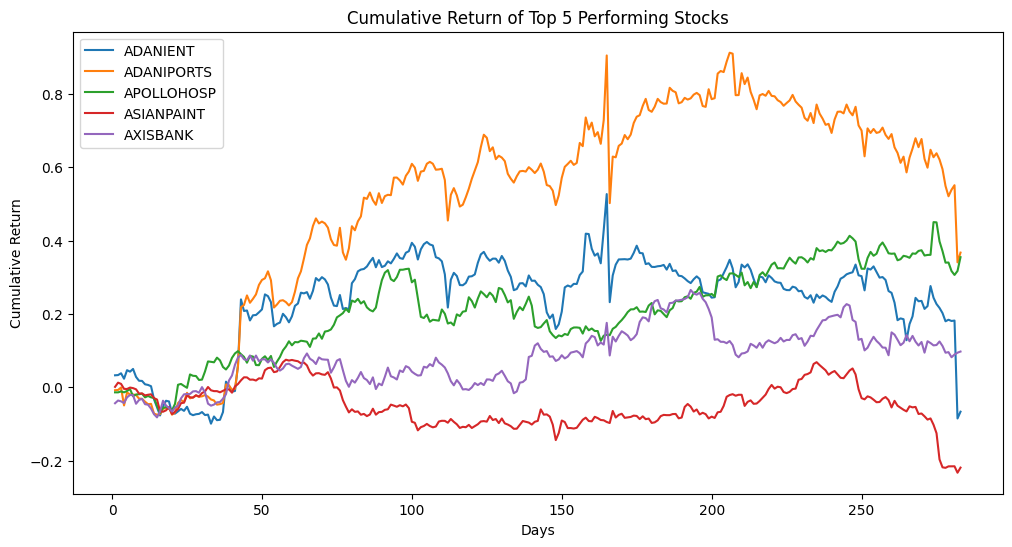

In [6]:
# select top 5
top5 = cum_df.head(5)

plt.figure(figsize=(12,6))

for ticker in top5["Ticker"]:
    df = pd.read_csv(folder / f"{ticker}.csv")
    df["cumulative_return"] = (1 + df["daily_return"]).cumprod() - 1
    plt.plot(df["cumulative_return"], label=ticker)

plt.title("Cumulative Return of Top 5 Performing Stocks")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


In [7]:
sector_path = Path(r"C:\Users\Bhuvaneshwari\Downloads\Sector_data - Sheet1.xlsx")

sector_df = pd.read_excel(sector_path)

# Clean ticker column
sector_df["Ticker"] = sector_df["Symbol"].astype(str).str.split(":").str[-1].str.strip().str.upper()

# Normalize sector column name
sector_df = sector_df.rename(columns={"sector": "Sector"})

# Show result
print("Cleaned sector file:")
print(sector_df[["Ticker", "Sector"]].head().to_string(index=False))


Cleaned sector file:
    Ticker        Sector
ADANIGREEN MISCELLANEOUS
ADANIPORTS MISCELLANEOUS
APOLLOHOSP MISCELLANEOUS
ASIANPAINT        PAINTS
  AXISBANK       BANKING


In [8]:
results = []

for file in folder.glob("*.csv"):
    ticker = file.stem.upper()
    df = pd.read_csv(file)

    df["cumulative_return"] = (1 + df["daily_return"]).cumprod() - 1
    final_return = df["cumulative_return"].iloc[-1]

    results.append([ticker, final_return])

returns_df = pd.DataFrame(results, columns=["Ticker", "CumulativeReturn"])

# Merge with sector_df from the previous cell
merged = returns_df.merge(sector_df[["Ticker", "Sector"]], on="Ticker", how="left")

# Show any tickers that did not match a sector
missing = merged[merged["Sector"].isna()]["Ticker"].tolist()

print("Number of tickers:", len(merged))
print("Tickers without sector mapping:", missing)


Number of tickers: 50
Tickers without sector mapping: ['ADANIENT', 'BHARTIARTL', 'BRITANNIA', 'TATACONSUM']


In [ ]:
sector_perf = merged.dropna(subset=["Sector"]) \
                    .groupby("Sector")["CumulativeReturn"].mean() \
                    .reset_index()

sector_perf = sector_perf.sort_values("CumulativeReturn", ascending=False)

print("Sector performance:")
print(sector_perf)

plt.figure(figsize=(12,5))
plt.bar(sector_perf["Sector"], sector_perf["CumulativeReturn"])
plt.xticks(rotation=45)
plt.ylabel("Average Yearly Return")
plt.title("Average Yearly Return by Sector")
plt.show()


In [ ]:
returns_data = {}

for file in folder.glob("*.csv"):
    ticker = file.stem.upper()
    df = pd.read_csv(file, parse_dates=["date"])
    df = df.sort_values("date")

    # store daily_return as a column
    returns_data[ticker] = df["daily_return"].values

# Create a single DataFrame
returns_df = pd.DataFrame(returns_data)

print("Shape of correlation DataFrame:", returns_df.shape)
returns_df.head()


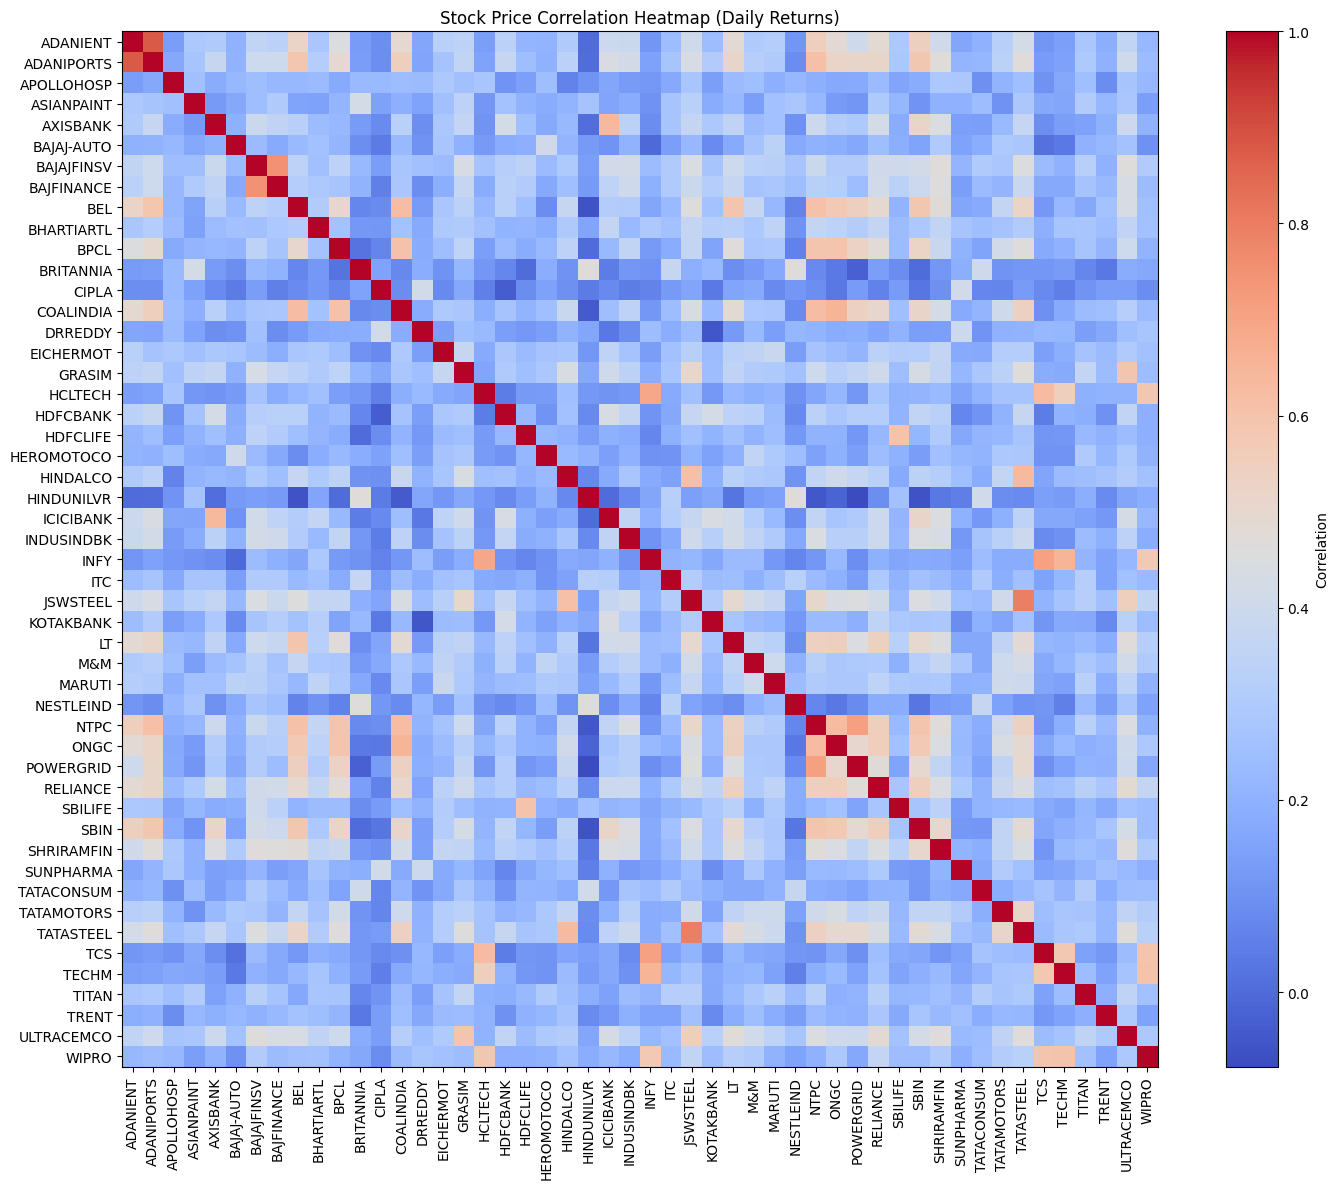

In [11]:
corr_matrix = returns_df.corr()
corr_matrix.head()

plt.figure(figsize=(15, 12))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

plt.xticks(np.arange(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(np.arange(len(corr_matrix)), corr_matrix.columns)

plt.title("Stock Price Correlation Heatmap (Daily Returns)")
plt.tight_layout()
plt.show()


In [ ]:
out_dir = folder.parent / "monthly_top5"
out_dir.mkdir(exist_ok=True)

rows = []

# Build monthly returns per ticker
for file in folder.glob("*.csv"):
    ticker = file.stem.upper()
    df = pd.read_csv(file, parse_dates=["date"])
    df = df.sort_values("date")

    # Resample monthly: take first and last close of each month
    monthly = df.set_index("date")["close"].resample("M").agg(["first", "last"]).dropna()
    if monthly.empty:
        continue

    monthly["monthly_return"] = (monthly["last"] - monthly["first"]) / monthly["first"]
    monthly = monthly.reset_index() 

    for _, r in monthly.iterrows():
        month_label = r["date"].strftime("%Y-%m")
        rows.append([ticker, month_label, r["monthly_return"]])

# Convert to DataFrame
monthly_df = pd.DataFrame(rows, columns=["Ticker", "Month", "MonthlyReturn"])

# Save full monthly returns (optional)
monthly_df.to_csv(out_dir / "all_monthly_returns.csv", index=False)

# For each month, find top5 gainers and top5 losers and save + plot
months = sorted(monthly_df["Month"].unique())

for m in months:
    mdf = monthly_df[monthly_df["Month"] == m].copy()
    mdf = mdf.dropna(subset=["MonthlyReturn"])

    top5 = mdf.sort_values("MonthlyReturn", ascending=False).head(5)
    bot5 = mdf.sort_values("MonthlyReturn", ascending=True).head(5)

    # Save tables
    top5.to_csv(out_dir / f"{m}_top5_gainers.csv", index=False)
    bot5.to_csv(out_dir / f"{m}_top5_losers.csv", index=False)

    # Plot side-by-side bar chart (gainers left, losers right)
    fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
    axes[0].bar(top5["Ticker"], top5["MonthlyReturn"])
    axes[0].set_title(f"{m} Top 5 Gainers")
    axes[0].set_ylabel("Monthly Return")
    axes[0].tick_params(axis='x', rotation=45)

    axes[1].bar(bot5["Ticker"], bot5["MonthlyReturn"])
    axes[1].set_title(f"{m} Top 5 Losers")
    axes[1].tick_params(axis='x', rotation=45)

    plt.suptitle(f"Top 5 Gainers & Losers — {m}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save figure
    fig_path = out_dir / f"{m}_gainers_losers.png"
    plt.savefig(fig_path, dpi=150)
    plt.close(fig)

print("Done. CSVs and plots saved in:", out_dir)
print("Example files:", list(out_dir.glob("*.csv"))[:6])


In [ ]:
folder = Path(r"C:\Users\Bhuvaneshwari\Downloads\data\per_ticker_csvs")

# Build a summary table: first and last close per ticker
rows = []
for f in folder.glob("*.csv"):
    ticker = f.stem.upper()
    df = pd.read_csv(f, parse_dates=["date"]).sort_values("date")
    first_close = df["close"].iloc[0]
    last_close  = df["close"].iloc[-1]
    yearly_return = (last_close - first_close) / first_close
    rows.append([ticker, first_close, last_close, yearly_return, df["volume"].mean()])

summary = pd.DataFrame(rows, columns=["Ticker","FirstClose","LastClose","YearlyReturn","AvgVolume"])

# Top 10 Green (highest yearly_return)
top10_green = summary.sort_values("YearlyReturn", ascending=False).head(10)
# Top 10 Loss (lowest yearly_return)
top10_loss = summary.sort_values("YearlyReturn", ascending=True).head(10)

# Market summary
green_count = (summary["YearlyReturn"] > 0).sum()
red_count   = (summary["YearlyReturn"] <= 0).sum()
avg_price   = summary["LastClose"].mean()
avg_volume  = summary["AvgVolume"].mean()

market_summary = {
    "green_count": green_count,
    "red_count": red_count,
    "avg_last_close": avg_price,
    "avg_volume": avg_volume
}

# Save results so SQL/Streamlit/PowerBI can use them
out = folder.parent / "final_summary"
out.mkdir(exist_ok=True)
top10_green.to_csv(out / "top10_green.csv", index=False)
top10_loss.to_csv(out / "top10_loss.csv", index=False)
pd.DataFrame([market_summary]).to_csv(out / "market_summary.csv", index=False)

print("Top 10 Green:\n", top10_green[["Ticker","YearlyReturn"]])
print("\nTop 10 Loss:\n", top10_loss[["Ticker","YearlyReturn"]])
print("\nMarket summary:", market_summary)


In [14]:
#connecting DB
import pymysql
conn = pymysql.connect(
    host="localhost",
    user="root",
    password="123456789",
    database="stock_analysis"
)
cursor = conn.cursor()

# Load the sector Excel file
sector_path = r"C:\Users\Bhuvaneshwari\Downloads\Sector_data - Sheet1.xlsx"
df = pd.read_excel(sector_path)

# Extract ticker from Symbol column
df["Ticker"] = df["Symbol"].str.split(":").str[-1].str.strip().str.upper()

# Insert rows into MySQL
for _, row in df.iterrows():
    cursor.execute("""
        INSERT INTO stocks (ticker, company, sector)
        VALUES (%s, %s, %s)
        ON DUPLICATE KEY UPDATE company=VALUES(company), sector=VALUES(sector)
    """, (row["Ticker"], row["COMPANY"], row["sector"]))

conn.commit()
cursor.close()
conn.close()

print("Inserted sector data into MySQL.")

Inserted sector data into MySQL.


In [ ]:
# MySQL connection (you already used this earlier)
conn = pymysql.connect(
    host="localhost",
    user="root",
    password="123456789",
    database="stock_analysis",
    autocommit=False
)
cursor = conn.cursor()

# Folder with your per-ticker CSVs
folder = Path(r"C:\Users\Bhuvaneshwari\Downloads\data\per_ticker_csvs")

files = sorted(folder.glob("*.csv"))
print("Found", len(files), "CSV files. Starting load...")

batch_size = 500

for f in files:
    ticker = f.stem.upper()
    df = pd.read_csv(f, parse_dates=["date"])
    df = df.sort_values("date").reset_index(drop=True)

    # prepare records as tuples for executemany
    records = []
    for _, r in df.iterrows():
        # handle NaN volume
        vol = int(r["volume"]) if (not pd.isna(r.get("volume"))) else None
        # date
        date_val = r["date"].to_pydatetime() if not pd.isna(r["date"]) else None
        records.append((
            ticker,
            date_val,
            float(r["open"]) if not pd.isna(r["open"]) else None,
            float(r["high"]) if not pd.isna(r["high"]) else None,
            float(r["low"])  if not pd.isna(r["low"])  else None,
            float(r["close"])if not pd.isna(r["close"])else None,
            vol,
            float(r["daily_return"]) if not pd.isna(r.get("daily_return")) else None
        ))

    # insert in chunks
    insert_sql = """
    INSERT IGNORE INTO prices
      (ticker, date, open, high, low, close, volume, daily_return)
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
    """
    for i in range(0, len(records), batch_size):
        chunk = records[i:i+batch_size]
        cursor.executemany(insert_sql, chunk)
    conn.commit()
    print(f"  Inserted {len(records)} rows for {ticker}")

cursor.close()
conn.close()
print("Finished loading all CSVs into prices.")


In [ ]:
conn = pymysql.connect(host="localhost", user="root", password="123456789", database="stock_analysis")
cur = conn.cursor()

# total rows
cur.execute("SELECT COUNT(*) FROM prices")
print("Total rows in prices:", cur.fetchone()[0])

# distinct tickers
cur.execute("SELECT COUNT(DISTINCT ticker) FROM prices")
print("Distinct tickers:", cur.fetchone()[0])

# rows per ticker
cur.execute("SELECT ticker, COUNT(*) as n FROM prices GROUP BY ticker ORDER BY n DESC LIMIT 5")
print("Top 5 tickers by row-count:")
for row in cur.fetchall():
    print(row)

cur.close()
conn.close()


In [ ]:
# connect to MySQL
conn = pymysql.connect(
    host="localhost",
    user="root",
    password="123456789",
    database="stock_analysis"
)

query = """
WITH first_last AS (
  SELECT ticker, MIN(date) AS start_date, MAX(date) AS end_date
  FROM prices
  GROUP BY ticker
)
SELECT pstart.ticker,
       (pend.close - pstart.close) / pstart.close AS yearly_return
FROM first_last fl
JOIN prices pstart ON pstart.ticker = fl.ticker AND pstart.date = fl.start_date
JOIN prices pend   ON pend.ticker   = fl.ticker AND pend.date   = fl.end_date
ORDER BY yearly_return DESC
LIMIT 10;
"""

df_top10 = pd.read_sql(query, conn)
print(df_top10)

conn.close()


In [ ]:
conn = pymysql.connect(
    host="localhost",
    user="root",
    password="123456789",
    database="stock_analysis"
)

df = pd.read_sql("SELECT * FROM prices LIMIT 5", conn)
print(df)

conn.close()